Building Models for Building Energy Prediction

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Hyperparameter Tuning and Model Optimisation](#part-3)


# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you must load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. For plotting, various visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and that the installation will be successful in the provided Docker container (in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
1.1.1 Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 32MB, and to run locally with all CPU cores on your machine

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext 
from pyspark import SparkConf
from pyspark.sql import functions as F
from pyspark.ml.feature import Imputer
from pyspark.sql.window import Window
from pyspark.sql.types import NumericType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pyspark.ml.evaluation import Evaluator
import numpy as np

In [2]:
#Setting up Spark's configuration
conf = (
    SparkConf()
    .setAppName("FIT5202_A2A_EnergyPrediction")
    .set("spark.driver.memory", "10g")   # set driver memory
    .set("spark.executor.memory", "10g") # in case you use executors later
    .set("spark.sql.files.maxPartitionBytes", str(32*1024*1024))  # 32MB
    .setMaster("local[*]")
)
spark = SparkSession.builder.config(conf=conf).getOrCreate()

sc = spark.sparkContext
sc.setLogLevel('ERROR')


1.1.2 Write code to define the schemas for the datasets, following the data types suggested in the metadata file. 

In [3]:
from pyspark.sql.types import ( StructType, StructField, IntegerType, StringType, TimestampType, DoubleType, DecimalType )

#manually defining schemas for each file

meters_schema = StructType([
    StructField("building_id", StringType(), False),
    StructField("meter_type", StringType(), True),       
    StructField("ts", TimestampType(), True),
    StructField("value", DoubleType(), True),             
    StructField("row_id", StringType(), False),
])

buildings_schema = StructType([
    StructField("site_id", StringType(), False),
    StructField("building_id", StringType(), False),
    StructField("primary_use", StringType(), True),
    StructField("square_feet", IntegerType(), True),
    StructField("floor_count", IntegerType(), True),
    StructField("row_id", StringType(), False),
    StructField("year_built", IntegerType(), True),
    StructField("latent_y", IntegerType(), True),
    StructField("latent_s", DoubleType(), True),
    StructField("latent_r", IntegerType(), True),
])

weather_schema = StructType([
    StructField("site_id", StringType(), False),
    StructField("timestamp", TimestampType(), True),
    StructField("air_temperature", DoubleType(), True),
    StructField("cloud_coverage", DoubleType(), True), #If read as Int, will read each row as null, so read as Double
    StructField("dew_temperature", DoubleType(), True),
    StructField("sea_level_pressure", DoubleType(), True),
    StructField("wind_direction", DoubleType(), True), #If read as Int, will read each row as null, so read as Double
    StructField("wind_speed", DoubleType(), True),
])

1.1.3 Using your schemas, load the CSV files into separate data frames. Print the schemas of all data frames. 

In [4]:
#Reading files, printing schema and checking values
meters = spark.read.csv("meters.csv", header=True, schema=meters_schema)
buildings = spark.read.csv("building_information.csv", header=True, schema=buildings_schema)
weather = spark.read.csv("weather.csv", header=True, schema=weather_schema)

meters.printSchema(); buildings.printSchema(); weather.printSchema()
meters.show(5);buildings.show(5);weather.show(5)

root
 |-- building_id: string (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- value: double (nullable = true)
 |-- row_id: string (nullable = true)

root
 |-- site_id: string (nullable = true)
 |-- building_id: string (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: string (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: integer (nullable = true)
 |-- latent_s: double (nullable = true)
 |-- latent_r: integer (nullable = true)

root
 |-- site_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- air_temperature: double (nullable = true)
 |-- cloud_coverage: double (nullable = true)
 |-- dew_temperature: double (nullable = true)
 |-- sea_level_pressure: double (nullable = true)
 |-- wind_direction: double (nullable = true)
 |-- wind_speed: double (nullable = true)

+-------

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In this section, we primarily have three tasks:  
1.2.1 The dataset includes sensors with hourly energy measurements. However, as a grid operator, we don’t need this level of granularity and lowering it can reduce the amount of data we need to process. For each building, we will aggregate the metered energy consumption in 6-hour intervals (0:00-5:59, 6:00-11:59, 12:00-17:59, 18:00-23:59). This will be our target (label) column for this prediction. Perform the aggregation for each building.


In [5]:
#Splitting timestamp into date/hour
meters = meters.withColumn("date", F.to_date("ts")).withColumn("hour", F.hour("ts"))

#Binning for aggregation
meters = meters.withColumn(
    "hour_block",
    F.when((F.col("hour")<=5),  F.lit("00-06"))
     .when((F.col("hour")<=11), F.lit("06-12"))
     .when((F.col("hour")<=17), F.lit("12-18"))
     .otherwise(F.lit("18-24"))
)

#Aggregate total energy within the 6 hours block, note that we do not care about row_id, so we won't be keeping it
meter_6h = (meters.groupBy("building_id", "date", "hour_block")#,"meter_type"
              .agg(F.sum("value").alias("energy_6h")))

meter_6h.show()

+-----------+----------+----------+------------------+
|building_id|      date|hour_block|         energy_6h|
+-----------+----------+----------+------------------+
|        917|2022-01-01|     00-06|         2844.3255|
|        245|2022-01-01|     12-18|            272.57|
|        917|2022-01-01|     12-18|          5313.558|
|       1286|2022-01-01|     12-18|        29241.4776|
|        167|2022-01-02|     00-06|          582.4664|
|        800|2022-01-02|     12-18|           4694.96|
|        911|2022-01-02|     12-18|         4539.4423|
|       1397|2022-01-02|     18-24|               0.0|
|       1207|2022-01-03|     12-18| 905.6530000000001|
|        945|2022-01-03|     18-24| 6714.954000000001|
|        962|2022-01-03|     18-24|4586.4400000000005|
|        236|2022-01-04|     00-06|          425.5127|
|        874|2022-01-04|     00-06|           5656.35|
|       1107|2022-01-04|     00-06|        120913.976|
|       1366|2022-01-04|     12-18| 5289.544200000001|
|       11

**NOTE:** When calculating the aggregate energy readings, I aggregate them for each whole building, disregarding the different meter_types. That is because, from what I understood (looking at this ED post https://edstem.org/au/courses/26389/discussion/2932284) , the label needs to be the TOTAL energy per building, so it is unimportant to keep it divided across the different meter type (which indicate different types of energy) 

In the weather dataset, there are some missing values (null or empty strings). It may lower the quality of our model. Imputation is a way to deal with those missing values. Imputation is the process of replacing missing values in a dataset with substituted, or "imputed," values. It's a way to handle gaps in your data so that you can still analyse it effectively without having to delete incomplete records.  
1.2.2 Refer to the Spark MLLib imputation API and fill in the missing values in the weather dataset. You can use mean values as the strategy.  https://spark.apache.org/docs/3.5.5/api/python/reference/api/pyspark.ml.feature.Imputer.html

In [6]:
#Code Notes: This code will impute the missing values with the following logic:
# 1- if available, fill with day's average value
# 2- if day is all null, fill with the site's mean value
# 3- if the whole site has null values (hopefully not) fill with the global mean

imp_cols = ["air_temperature","cloud_coverage","dew_temperature",
            "sea_level_pressure","wind_direction","wind_speed"]

# Add date and define windows
w_imp = weather.withColumn("date", F.to_date("timestamp"))
w_day   = Window.partitionBy("site_id", "date")   # site-day
w_site  = Window.partitionBy("site_id")           # site-wide
w_all   = Window.partitionBy()                    # global

for col in imp_cols:
    day_avg   = f"{col}_day_avg"
    site_avg  = f"{col}_site_avg"
    glob_avg  = f"{col}_global_avg"

    # Calculate averages for imputation
    w_imp = (w_imp
        .withColumn(day_avg,  F.avg(col).over(w_day))
        .withColumn(site_avg, F.avg(col).over(w_site))
        .withColumn(glob_avg, F.avg(col).over(w_all))
        # impute with day -> site -> global, then round to 2 dp
        .withColumn(
            col,
            F.round(
                F.when(F.col(col).isNull(),
                       F.coalesce(F.col(day_avg),F.col(site_avg),F.col(glob_avg)))
                 .otherwise(F.col(col)),
                2
            )
        )
    )

# drop helpers + date
helper_cols = [f"{c}_day_avg" for c in imp_cols] + \
              [f"{c}_site_avg" for c in imp_cols] + \
              [f"{c}_global_avg" for c in imp_cols]
w_imp = w_imp.drop(*helper_cols, "date")

# sanity check
w_imp.orderBy("site_id","timestamp").show(20, truncate=False)

+-------+-------------------+---------------+--------------+---------------+------------------+--------------+----------+
|site_id|timestamp          |air_temperature|cloud_coverage|dew_temperature|sea_level_pressure|wind_direction|wind_speed|
+-------+-------------------+---------------+--------------+---------------+------------------+--------------+----------+
|0      |2022-01-01 00:00:00|25.0           |6.0           |20.0           |1019.7            |0.0           |0.0       |
|0      |2022-01-01 01:00:00|24.4           |4.29          |21.1           |1020.2            |70.0          |1.5       |
|0      |2022-01-01 02:00:00|22.8           |2.0           |21.1           |1020.2            |0.0           |0.0       |
|0      |2022-01-01 03:00:00|21.1           |2.0           |20.6           |1020.1            |0.0           |0.0       |
|0      |2022-01-01 04:00:00|20.0           |2.0           |20.0           |1020.0            |250.0         |2.6       |
|0      |2022-01-01 05:0

We know that different seasons may affect energy consumption—for instance, a heater in winter and a cooler in summer. Extracting peak seasons (summer and winter) or off-peak seasons (Spring and Autumn) might be more useful than directly using the month as numerical values.   
1.2.3 The dataset has 16 sites in total, whose locations may span across different countries. Add a column (peak/off-peak) to the weather data frame based on the average air temperature. The top 3 hottest months and the 3 coldest months are considered “peak”, and the rest of the year is considered “off-peak”. 

In [7]:
w_imp = w_imp.withColumn("month", F.month("timestamp"))

#Finding average air temperature per month
site_month = (w_imp.groupBy("site_id", "month")
                    .agg(F.avg("air_temperature").alias("avg_air_temp")))


#Creating window for hottest and coldest months (ordered ascending/descending)
w_hot  = Window.partitionBy("site_id").orderBy(F.col("avg_air_temp").desc())
w_cold = Window.partitionBy("site_id").orderBy(F.col("avg_air_temp").asc())

#Getting top3/bottom 3 rows from windows to get hottest/coldest months
hot3  = (site_month.withColumn("rk", F.row_number().over(w_hot))
                    .where("rk <= 3")
                    .select("site_id", F.col("month")))
cold3 = (site_month.withColumn("rk", F.row_number().over(w_cold))
                    .where("rk <= 3")
                    .select("site_id", F.col("month")))

#Marking each peak with 1, will mark each non-peak with 0 (otherwise we will need to correct later anyway)
peak_months = hot3.unionByName(cold3).dropDuplicates(["site_id","month"]).withColumn("season_peak", F.lit(1))
w_imp = w_imp.join(peak_months, on=["site_id","month"], how="left")

#Filling NAs with 0 in season_peak (so 0 is off_peak, 1 is peak)
w_imp = w_imp.na.fill({"season_peak": 0})

w_imp.show(5)

+-------+-----+-------------------+---------------+--------------+---------------+------------------+--------------+----------+-----------+
|site_id|month|          timestamp|air_temperature|cloud_coverage|dew_temperature|sea_level_pressure|wind_direction|wind_speed|season_peak|
+-------+-----+-------------------+---------------+--------------+---------------+------------------+--------------+----------+-----------+
|      0|    1|2022-01-01 22:00:00|           26.7|          4.29|           18.3|            1016.9|         230.0|       3.1|          1|
|      0|    1|2022-01-01 23:00:00|           25.6|          4.29|           18.3|            1017.5|         230.0|       3.1|          1|
|      0|    1|2022-01-01 00:00:00|           25.0|           6.0|           20.0|            1019.7|           0.0|       0.0|          1|
|      0|    1|2022-01-01 01:00:00|           24.4|          4.29|           21.1|            1020.2|          70.0|       1.5|          1|
|      0|    1|2022-

Create a data frame with all relevant columns at this stage, we refer to this data frame as feature_df.

In [8]:
#applying modifications to weather dataset too
w_imp = (w_imp
           .withColumn("date", F.to_date("timestamp"))
           .withColumn("hour", F.hour("timestamp"))
           .withColumn("hour_block",
               F.when((F.col("hour")<=5),  F.lit("00-06"))
                .when((F.col("hour")<=11), F.lit("06-12"))
                .when((F.col("hour")<=17), F.lit("12-18"))
                .otherwise(F.lit("18-24"))
           ))

w_6h = (w_imp.groupBy("site_id","date","hour_block")
               .agg(
                   *[F.avg(c).alias("avg_"+c+"_6h") for c in imp_cols],
                    F.first("season_peak").alias("season_peak")
                   )
       )

#Joining with buildings through common site_id (expect around 1.5 million rows at this stage)
buildings_weather = buildings.join(w_6h, on="site_id", how="left")

#Creating feature_id df, we drop row_id as it is reduntant to the other 
#keys we already have (and does not match with buildings row_id)
feature_df = (buildings_weather.join(meter_6h, on=["building_id","date","hour_block"], how="inner")
                       .drop("row_id")) 

#Keeping feature dataframe in memory
feature_df.cache()
feature_df.show(5, truncate=False)

+-----------+----------+----------+-------+-----------+-----------+-----------+----------+--------+---------+--------+----------------------+---------------------+----------------------+-------------------------+---------------------+------------------+-----------+---------+
|building_id|date      |hour_block|site_id|primary_use|square_feet|floor_count|year_built|latent_y|latent_s |latent_r|avg_air_temperature_6h|avg_cloud_coverage_6h|avg_dew_temperature_6h|avg_sea_level_pressure_6h|avg_wind_direction_6h|avg_wind_speed_6h |season_peak|energy_6h|
+-----------+----------+----------+-------+-----------+-----------+-----------+----------+--------+---------+--------+----------------------+---------------------+----------------------+-------------------------+---------------------+------------------+-----------+---------+
|0          |2022-01-08|00-06     |0      |Education  |7432       |1          |2015      |15      |3.8711057|0       |16.866666666666664    |8.299999999999999    |15.1     

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
You can use either the CDA or the EDA method mentioned in Lab 5.  
Some ideas for CDA:  
a)	Older building may not be as efficient as new ones, therefore need more energy for cooling/heating. It’s not necessarily true though, if the buildings are built with higher standard or renovated later.  
b)	A multifloored or larger building obviously consumes more energy.  

In [9]:
#Print the Schema
feature_df.printSchema()

#Shape of feature+df
print((feature_df.count(), len(feature_df.columns)))

root
 |-- building_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour_block: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: integer (nullable = true)
 |-- latent_s: double (nullable = true)
 |-- latent_r: integer (nullable = true)
 |-- avg_air_temperature_6h: double (nullable = true)
 |-- avg_cloud_coverage_6h: double (nullable = true)
 |-- avg_dew_temperature_6h: double (nullable = true)
 |-- avg_sea_level_pressure_6h: double (nullable = true)
 |-- avg_wind_direction_6h: double (nullable = true)
 |-- avg_wind_speed_6h: double (nullable = true)
 |-- season_peak: integer (nullable = true)
 |-- energy_6h: double (nullable = true)

(1422506, 19)


1.	With the feature_df, write code to show the basic statistics:  
a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile;  
b) For each non-numeric column, display the top-5 values and the corresponding counts;  
c) For each boolean column, display the value and count. (note: pandas describe is allowed for this task.) (5%)

In [10]:
#a- Statistics for numeric columns
feature_df.describe().show()
#Statistic for non-numeric columns
non_num_cols = ['hour_block','primary_use']#,"meter_type"

#b- Showing top 5 values for non-numeric cols (or less if they have less than 5) and relative count
for c in non_num_cols:
    feature_df.groupBy(c).count().orderBy(F.desc("count")).limit(5).show(truncate=False)

#also looking at all of the different primary_uses for data exploration reference
feature_df.select('primary_use').distinct().show()

#c- value and count for each boolean column (note: they are registered as 1 or 0 ints, as it is easier to handle in ML)
feature_df.groupBy("season_peak").count().show()

+-------+-----------------+----------+-----------------+-----------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+---------------------+----------------------+-------------------------+---------------------+------------------+-------------------+------------------+
|summary|      building_id|hour_block|          site_id|primary_use|       square_feet|       floor_count|        year_built|          latent_y|          latent_s|          latent_r|avg_air_temperature_6h|avg_cloud_coverage_6h|avg_dew_temperature_6h|avg_sea_level_pressure_6h|avg_wind_direction_6h| avg_wind_speed_6h|        season_peak|         energy_6h|
+-------+-----------------+----------+-----------------+-----------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+---------------------+----------------------+-------------------------+----------

In [11]:
#SAMPLED STATISTICS (Using Pandas): They also include median, 25 and 75% percentile (and easier to read)
import pandas as pd

# Convert Spark DF to Pandas
pdf = feature_df.sample(fraction=0.1, seed=42).toPandas()
print(pdf.describe(percentiles=[0.25,0.5,0.75]))

print("=== Numeric Columns Summary ===")
print(pdf.describe(percentiles=[0.25, 0.5, 0.75]))

         square_feet    floor_count     year_built       latent_y  \
count  142534.000000  142534.000000  142534.000000  142534.000000   
mean    88194.965573       1.657829    1986.776053      22.068264   
std    106222.394675       2.024187      26.220410      19.374524   
min       356.000000       1.000000    1907.000000       0.000000   
25%     21657.000000       1.000000    1973.000000       9.000000   
50%     56343.000000       1.000000    1990.000000      17.000000   
75%    110272.000000       1.000000    2008.000000      27.000000   
max    875000.000000      26.000000    2023.000000      93.000000   

            latent_s       latent_r  avg_air_temperature_6h  \
count  142534.000000  142534.000000           142534.000000   
mean        4.565028       3.408569               16.137035   
std         0.576256       0.766622               10.336260   
min         2.551450       0.000000              -27.600000   
25%         4.148109       3.000000                9.233333   


2.	Explore the dataframe and write code to present two plots of multivariate analysis, describe your plots and discuss the findings from the plots. (5% each).  
○	150 words max for each plot’s description and discussion.  
○	Note: In the building metadata table, there are some latent columns (data that may or may not be helpful, their meanings is unknown due to privacy and data security concerns).  
○	Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc. You can refer to https://samplecode.link  


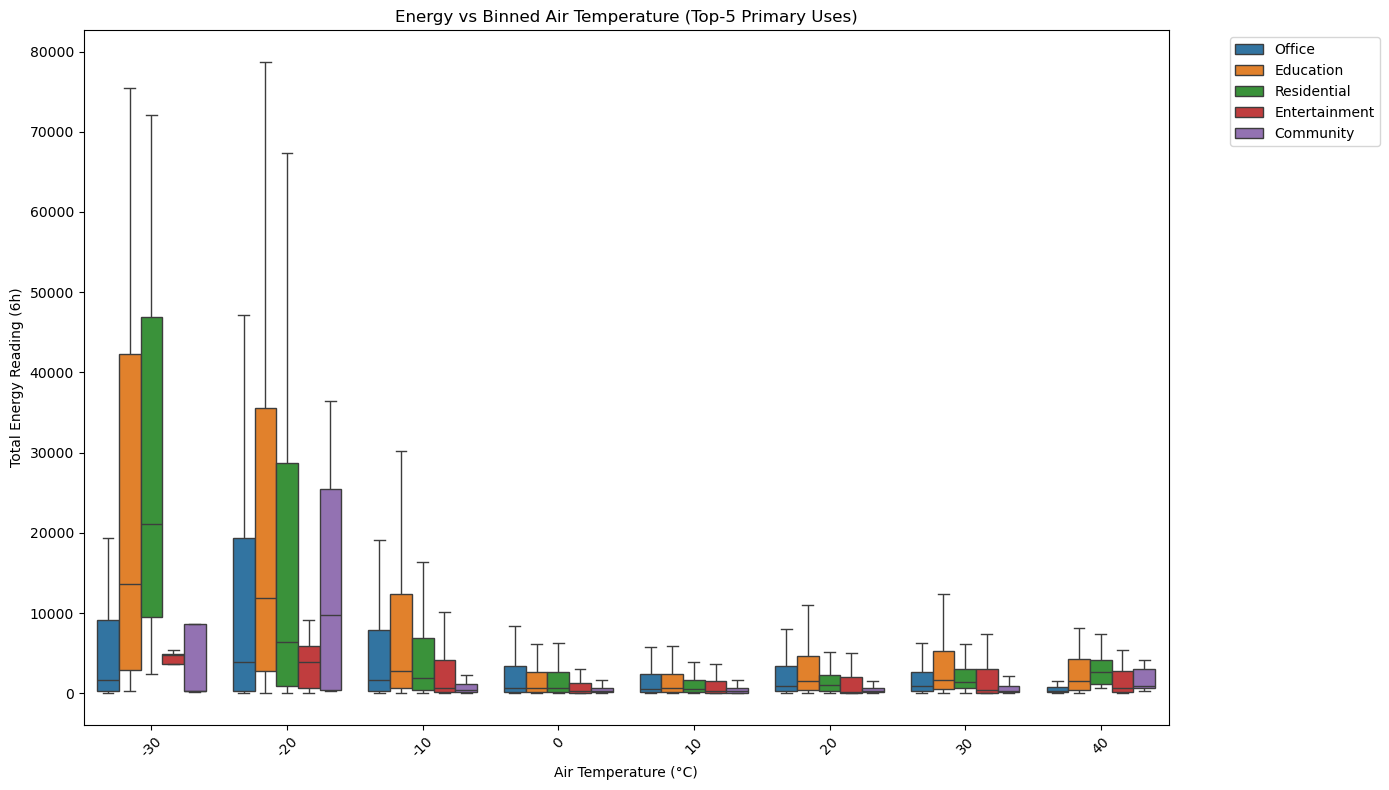

In [12]:
#Visualisation 1: Influence of air temperature on energy readings over different building primary use (only top 5 considered)
#getting top 5 categories
top5_primary = (
    feature_df.groupBy("primary_use")
    .count()
    .orderBy(F.desc("count"))
    .limit(5)
    .toPandas()["primary_use"].tolist()
)

#Filtering only top 5 uses to not clutter graph, binning air_temperature
feature_df_bin = (
    feature_df
    .filter(F.col("primary_use").isin(top5_primary))
    .withColumn("temp_bin", F.floor(F.col("avg_air_temperature_6h")/10)*10)
)

#Sampling for graph
pdf = feature_df_bin.select("temp_bin", "energy_6h", "primary_use")\
    .sample(0.05, seed=42).toPandas()

#Plotting
plt.figure(figsize=(14,8))
sns.boxplot(
    data=pdf,
    x="temp_bin",
    y="energy_6h",
    hue="primary_use",
    showfliers=False
)

plt.xticks(rotation=45)
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Total Energy Reading (6h)")
plt.title("Energy vs Binned Air Temperature (Top-5 Primary Uses)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This grouped box plot represents the variation of total energy by air temperature, representing with a different colour the 5 different top building uses identified.

From the plot, we may observe:
-  **air temperature**: is most likely gonna be an important feature, as evergy readings are clearly higher at lower temperatures, and decrease as the air temperature grows (which indicates a large portion of the energy is due to heating systems)
-  **building use**: across different building uses, the energy readings are different, but the uncertainty is also quite high... the building use seems to not be particularly important together with air temperature, but it may be useful when combined with other variables

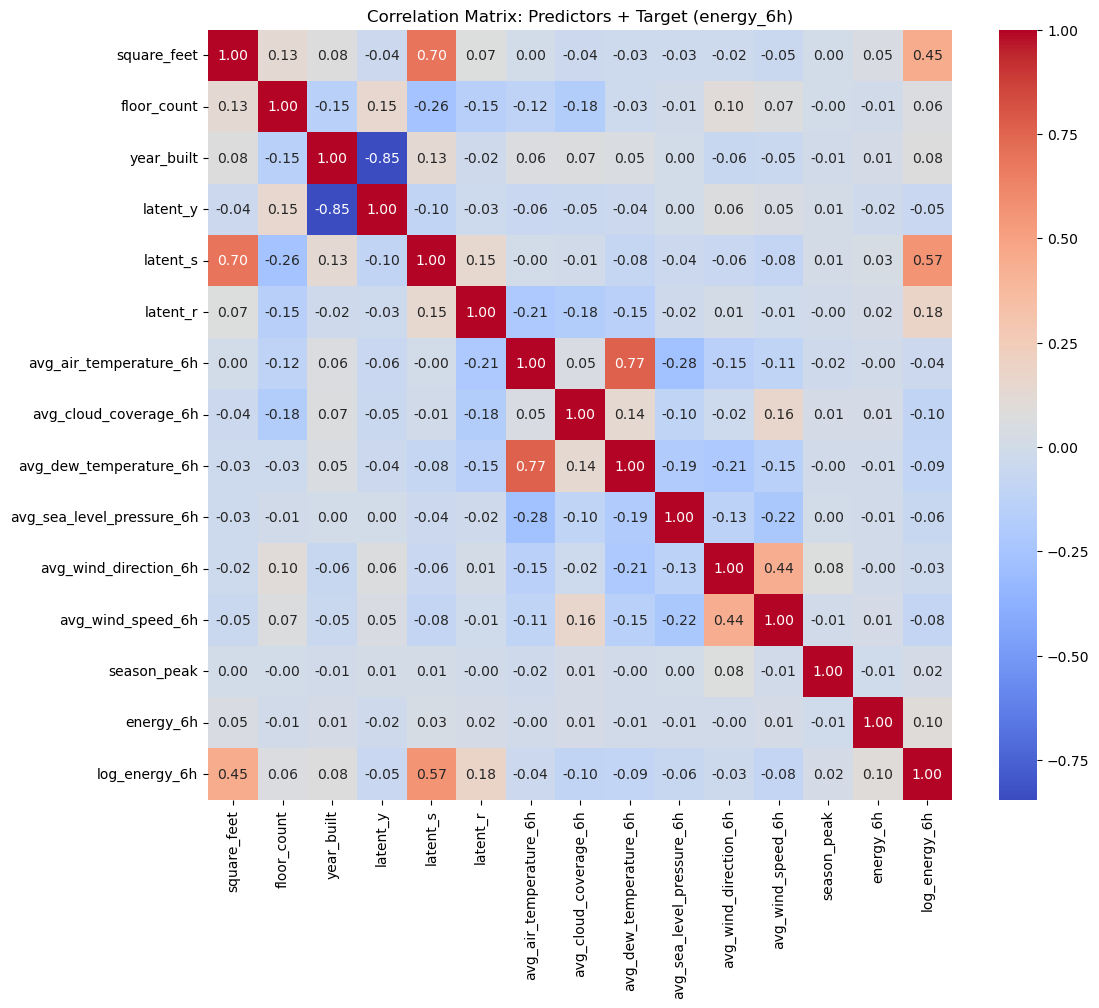

In [13]:
#Visualisation 2: Correlation matrix
predictors = [
    "square_feet", "floor_count", "year_built",
    "latent_y", "latent_s", "latent_r",
    "avg_air_temperature_6h", "avg_cloud_coverage_6h",
    "avg_dew_temperature_6h", "avg_sea_level_pressure_6h",
    "avg_wind_direction_6h", "avg_wind_speed_6h","season_peak"
]

# Add a new column with log-transformed square_feet
df_corr = feature_df.select(predictors + ["energy_6h"])

#looking at correlations with log energy_6h aswell, since our metric is based off of the log of target
df_corr = df_corr.withColumn("log_energy_6h", F.log1p(F.col("energy_6h")))

#sampling 10% for plotting
pdf = df_corr.sample(fraction=0.1, seed=42).toPandas()  
corr = pdf.corr(method="pearson")
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix: Predictors + Target (energy_6h)")
plt.show()

The above correlation matrix can relay informations about the relationships between features and between features and target. Notable insights:
-  **latent_s** seems to be highly correlated to floor_count and square_feet, (inversely to floor count) these seems to indicate that it is a compound feature, extracted through something like PCA, and we could consider it as info on the **dimensions of the building**
-  **latent_y** is highly correlated to the inverse of the year_build , so it seems to be a feature indicating **how new the building is** 
-  as for **latent_r** , it's meaning is still unclear, but it looks like it is unrelated to other variables from the building
-  the dimesions of the building (both latent_s and square feet) seem very important for the prediction, as they have positive correlation with the log of the label

+---------+------------------+
|    month|     avg_energy_6h|
+---------+------------------+
|  January|13472.009680255274|
| February| 14762.35980105986|
|    March| 66130.60143439863|
|    April|  77194.1613260873|
|      May| 71984.55795760018|
|     June|57061.284077387725|
|     July|4007.6923235548893|
|   August| 4139.381943077476|
|September|  4121.01997133694|
|  October| 3415.086247442079|
| November| 9923.469412440178|
| December| 4680.795496063246|
+---------+------------------+



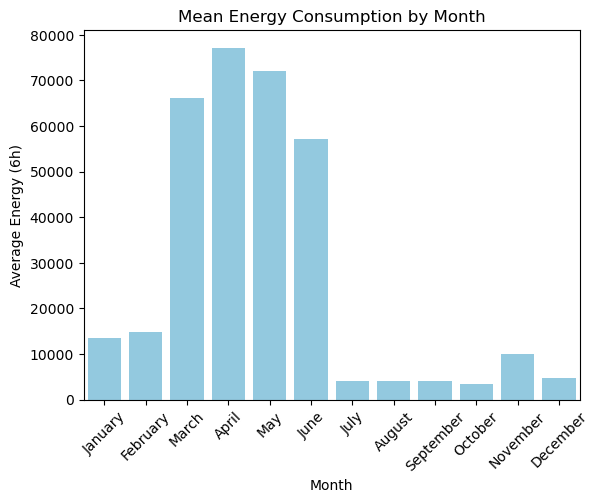

In [14]:
# Extract month name
with_month = feature_df.withColumn("month", F.date_format("date", "MMMM"))

# Aggregate mean energy by month
monthly_energy = (with_month
    .groupBy("month")
    .agg(F.mean("energy_6h").alias("avg_energy_6h"))
)

# Ensure correct order Jan → Dec
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

monthly_energy = (monthly_energy
    .withColumn("m_order",
        F.when(F.col("month")=="January",1)
         .when(F.col("month")=="February",2)
         .when(F.col("month")=="March",3)
         .when(F.col("month")=="April",4)
         .when(F.col("month")=="May",5)
         .when(F.col("month")=="June",6)
         .when(F.col("month")=="July",7)
         .when(F.col("month")=="August",8)
         .when(F.col("month")=="September",9)
         .when(F.col("month")=="October",10)
         .when(F.col("month")=="November",11)
         .when(F.col("month")=="December",12)
    )
    .orderBy("m_order")
    .drop("m_order")
)

monthly_energy.show()

pdf_month = monthly_energy.toPandas()

sns.barplot(data=pdf_month, x="month", y="avg_energy_6h", color="skyblue",
            order=month_order)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Average Energy (6h)")
plt.title("Mean Energy Consumption by Month")
plt.show()

**Monthly-Weekly energy consumption**

The energy consumption looks a bit unusual: we would except the consumption to be higher during the colder/ hotter months , so during January/February and July/August. Instead it looks like most of the energy cost is concentrated in the period between March and June. This is gonna be reflected in the peak_months that we defined as a feature.

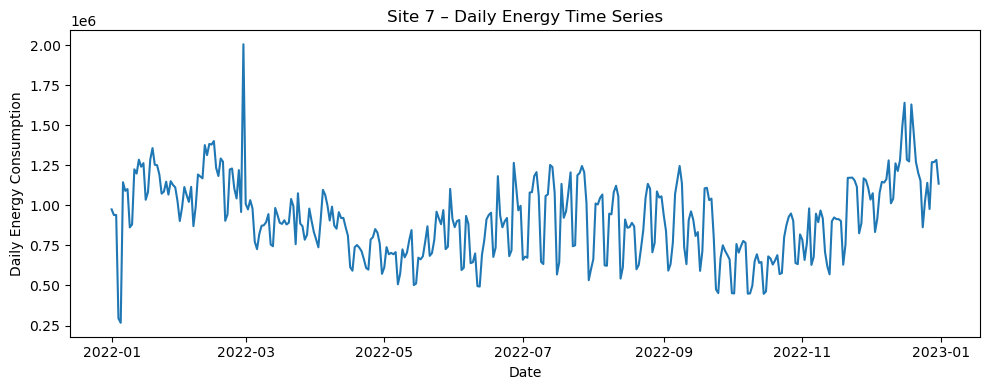

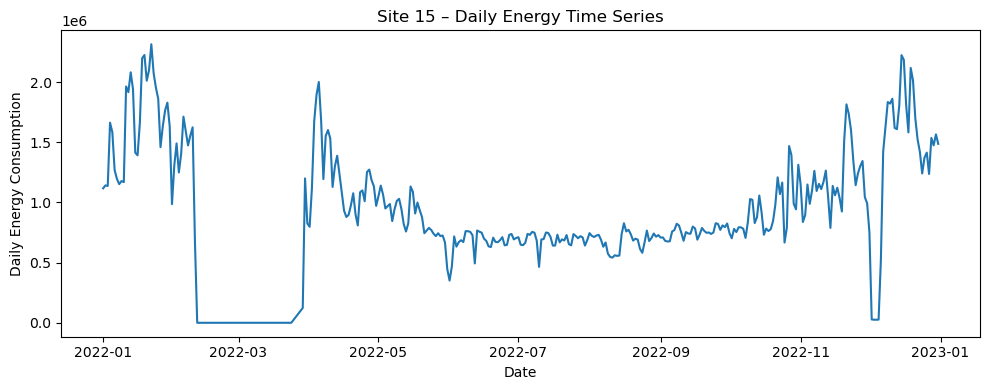

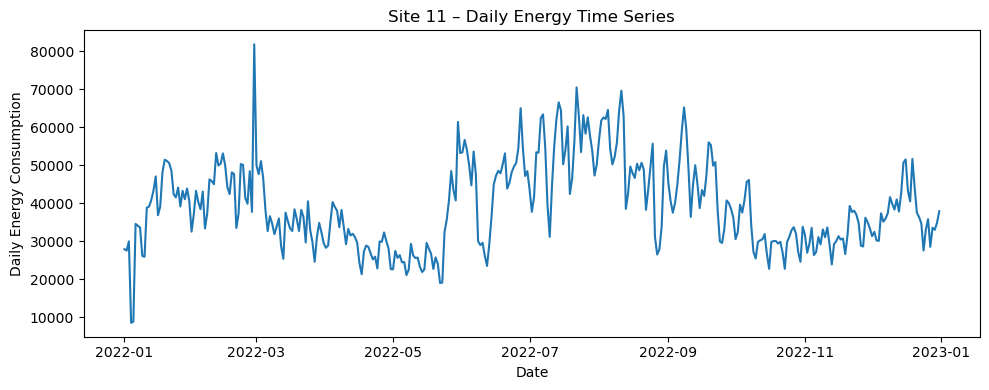

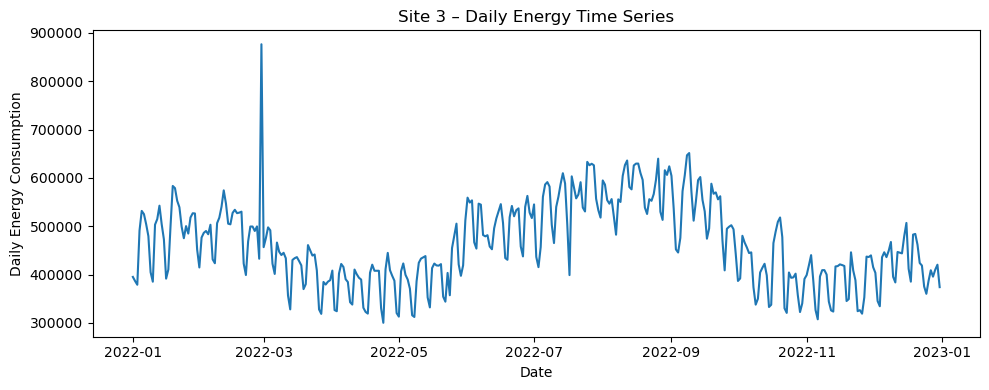

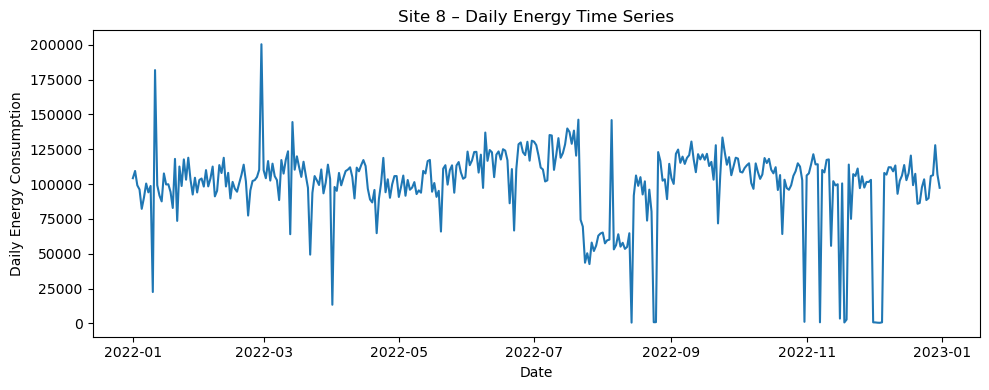

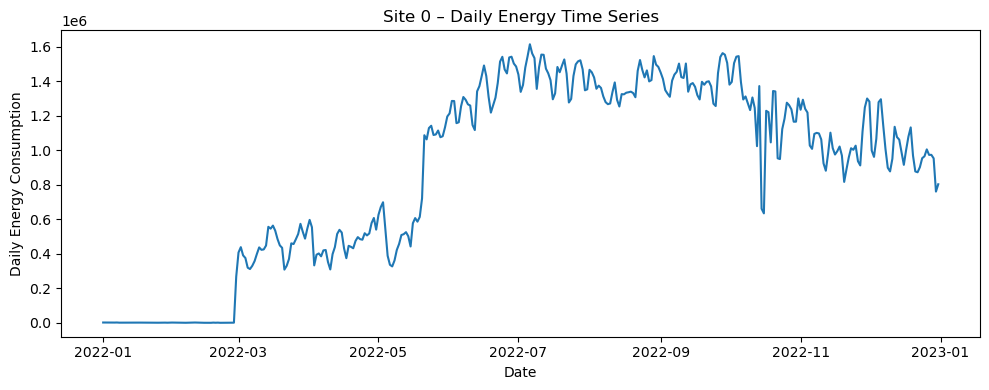

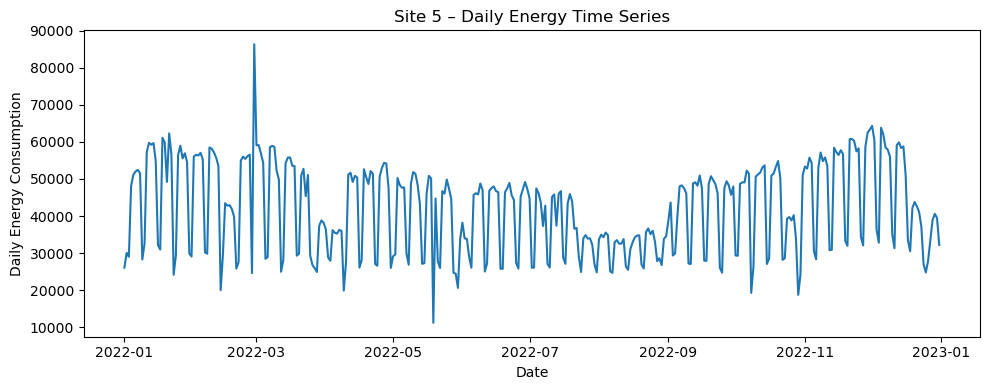

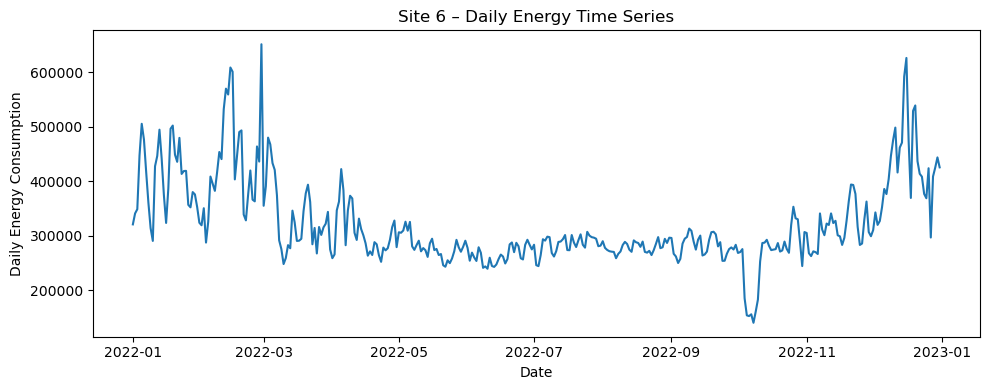

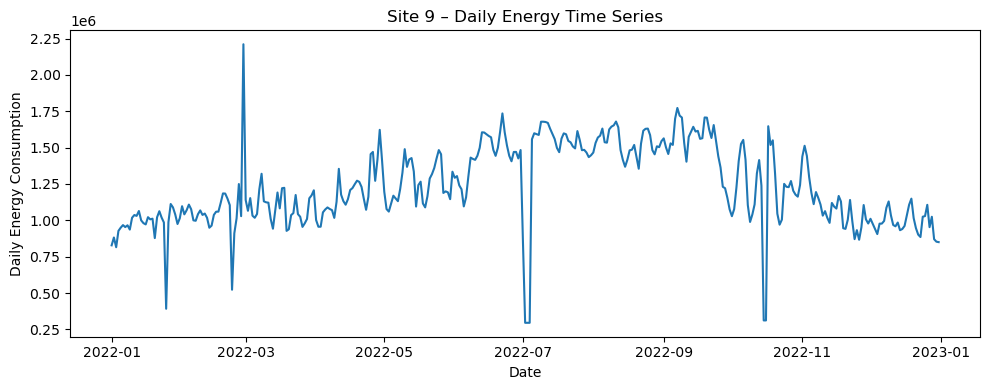

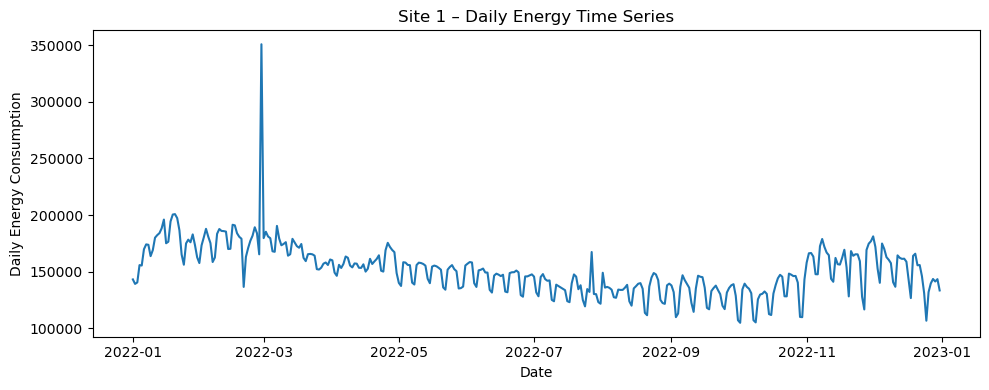

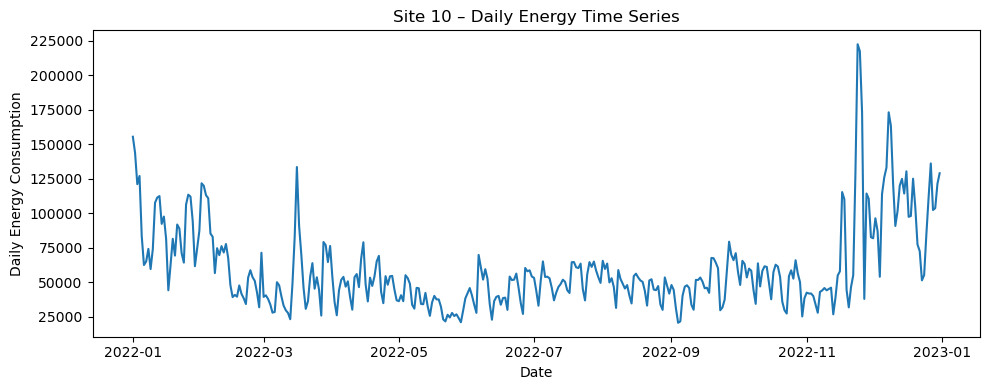

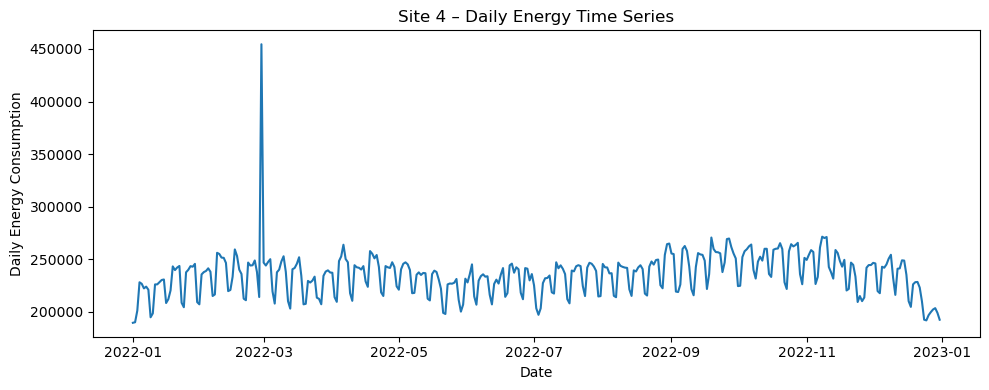

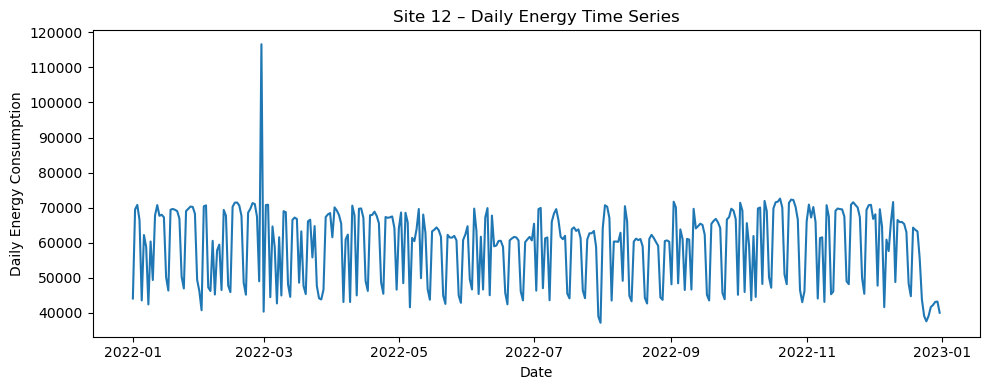

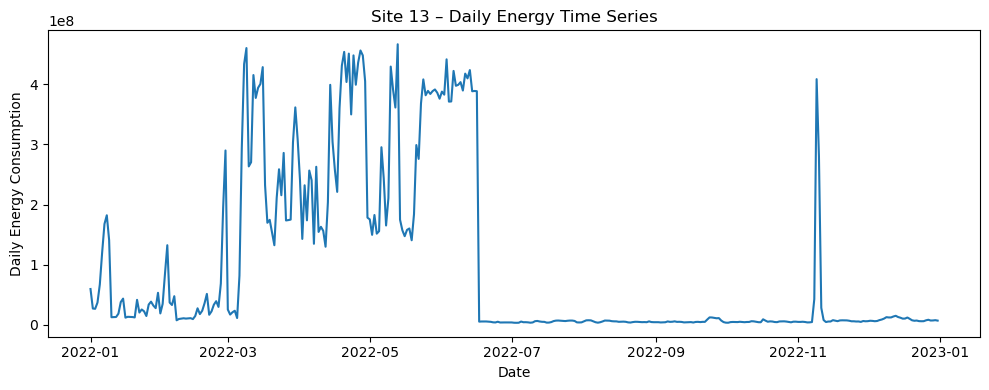

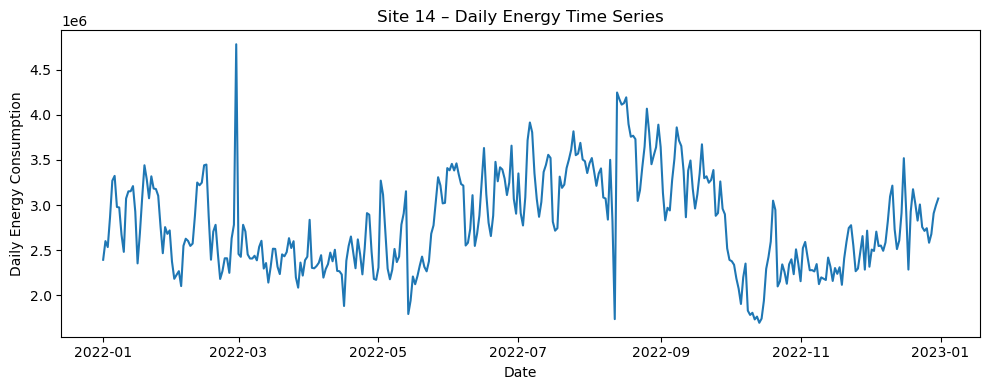

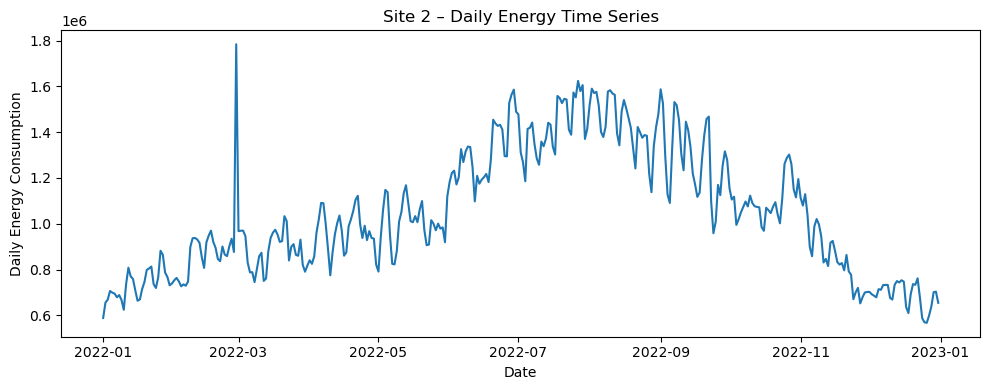

In [15]:
# Aggregate to daily energy per site
daily_df = (
    feature_df
    .withColumn("date", F.to_date("date"))  # ensure it's DateType
    .groupBy("site_id", "date")
    .agg(F.sum("energy_6h").alias("daily_energy"))
    .orderBy("site_id", "date")
)

# Collect distinct site_ids
site_ids = [row.site_id for row in daily_df.select("site_id").distinct().collect()]

# Plot for each site
for sid in site_ids:
    pdf = (
        daily_df.filter(F.col("site_id") == sid)
        .orderBy("date")
        .toPandas()
    )

    plt.figure(figsize=(10,4))
    plt.plot(pdf["date"], pdf["daily_energy"])
    plt.xlabel("Date")
    plt.ylabel("Daily Energy Consumption")
    plt.title(f"Site {sid} – Daily Energy Time Series")
    plt.tight_layout()
    plt.show()

In [16]:
# Which building in site 13 is responsible for such a weird plot?

site13_df = feature_df.filter(F.col("site_id") == 13)

# Aggregate daily energy by building
site13_daily = (
    site13_df.groupBy("building_id", "date")
    .agg(F.sum("energy_6h").alias("daily_energy"))
)

threshold = 1e08
# Find buildings with values above threshold
top_buildings = (
    site13_daily.filter(F.col("daily_energy") >= threshold)
    .groupBy("building_id")
    .agg(
        F.count("*").alias("days_above_threshold"),
        F.max("daily_energy").alias("max_daily_energy"),
        F.avg("daily_energy").alias("avg_daily_energy"),
    )
    .orderBy(F.desc("max_daily_energy"))
)

top_buildings.show(20, truncate=False)

+-----------+--------------------+----------------+-------------------+
|building_id|days_above_threshold|max_daily_energy|avg_daily_energy   |
+-----------+--------------------+----------------+-------------------+
|1099       |111                 |4.61160216726E8 |2.909815715572702E8|
+-----------+--------------------+----------------+-------------------+



**Observations:**

-  site 15, site 0 have long periods (a couple of months) where the energy readings have always been 0. We can deduce that the energy meters were not working during those periods, or the buildings on site were not open
-  site 13 show abnormally high values of energy readings (the scales is 2 orders higher compared to other plots), having a scale of $10^8$ compared to $10^6$ like most others. The reason seems to be building 1099, having abnormally high readings compared to its peers. We might consider dropping it as an anomaly

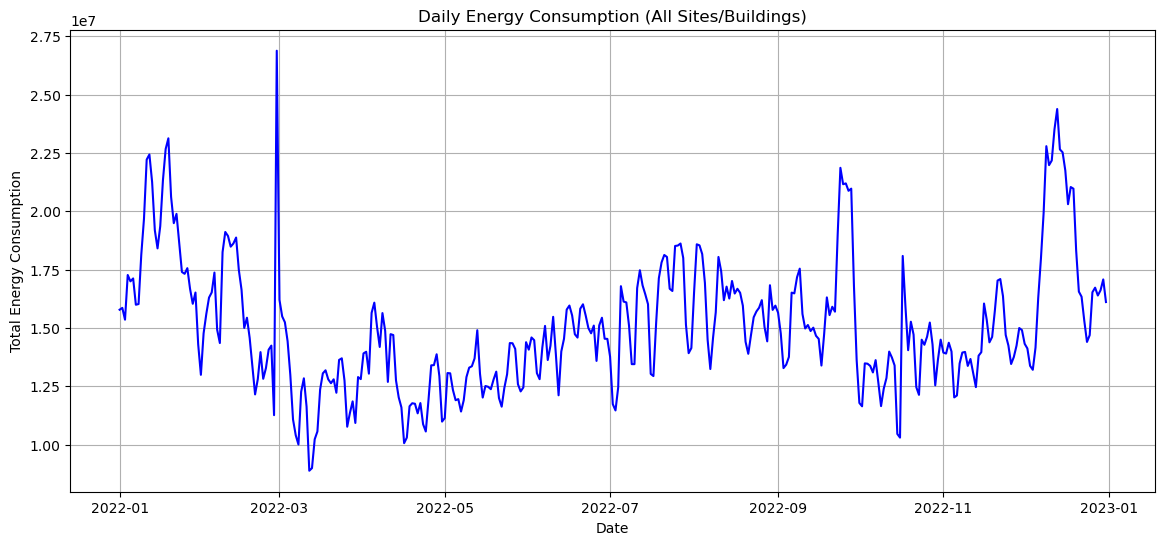

In [17]:
#dropping building 1099
feature_df = feature_df.filter(F.col("building_id") != 1099)


# Aggregate daily energy across all sites/buildings
daily_energy = (feature_df.groupBy("date")
                        .agg(F.sum("energy_6h").alias("daily_energy"))
                        .orderBy("date"))

# Convert to Pandas for plotting
daily_energy_pd = daily_energy.toPandas()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(daily_energy_pd["date"], daily_energy_pd["daily_energy"], color="blue")
plt.xlabel("Date")
plt.ylabel("Total Energy Consumption")
plt.title("Daily Energy Consumption (All Sites/Buildings)")
plt.grid(True)
plt.show()

As we can see, removing building 1099 has taken care of most of the outliers, and now the time series distribution looks more "normal", with peaks in the colder/hotter seasons.

+---------+------------------+
|  weekday|     avg_energy_6h|
+---------+------------------+
|   Monday| 3938.780148642641|
|  Tuesday| 4003.252460489112|
|Wednesday| 4022.809180582762|
| Thursday|3980.8467046897385|
|   Friday|3916.7700175375985|
| Saturday|3662.1578737295026|
|   Sunday| 3568.761205018726|
+---------+------------------+



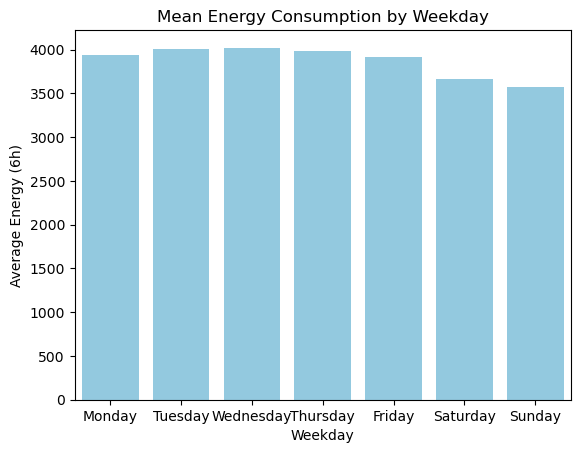

In [18]:
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

with_wd = feature_df.withColumn("weekday", F.date_format("date", "EEEE"))

weekday_energy = (with_wd
    .groupBy("weekday")
    .agg(F.mean("energy_6h").alias("avg_energy_6h"))
    .withColumn("wd_order",
        F.when(F.col("weekday")=="Monday", 1)
         .when(F.col("weekday")=="Tuesday", 2)
         .when(F.col("weekday")=="Wednesday", 3)
         .when(F.col("weekday")=="Thursday", 4)
         .when(F.col("weekday")=="Friday", 5)
         .when(F.col("weekday")=="Saturday", 6)
         .when(F.col("weekday")=="Sunday", 7)
    )
    .orderBy("wd_order")
    .drop("wd_order")
)

weekday_energy.show()

pdf = weekday_energy.toPandas()

sns.barplot(data=pdf, x="weekday", y="avg_energy_6h", color="skyblue",
            order=order)   # keep correct order in plot
plt.xlabel("Weekday")
plt.ylabel("Average Energy (6h)")
plt.title("Mean Energy Consumption by Weekday")
plt.show()

Looking at the energy consumption by day of the week, we observe that weekends tend to have lower energy consumptions compared to the rest of the week. This is probably because in the weekend most of the companies/schools are closed, and those are usually way bigger buildings, that consume higher amounts of energy

## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you must use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, should not be used to process the data; however, it’s fine to use them to display the result or evaluate your model.  
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a significant impact on the label column, which should be transformed), which features you are planning to use? Discuss the reasons for selecting them and how you plan to create/transform them.  
○	300 words max for the discussion  
○	Please only use the provided data for model building  
○	You can create/add additional features based on the dataset  
○	Hint - Use the insights from the data exploration/domain knowledge/statistical models to consider whether to create more feature columns, whether to remove some columns  

Considering what we've seen in the EDA, I plan to use the following features to build my model:
-  **weather features:** air temperature, cloud coverage, dew temperature will be included. I do not believe features such as the wind speed and direction will matter directly to the model, as they should not influence the amount of energy consumption logically
-  **building features:** If my assumption from EDA is correct, latent_s and latent_y can be used as a substitute to floor, square_feet and year_built. I will try both including/excluding latent_r since I am not quite sure of its significance. Primary use looks to be important and will be used as a categorical feature
-  **meter features:** here, meter_6h is our target, but I will use the 6h block and season_peak as features.
-  **outliers:** note that building 1099 has been deemed an outlier and dropped from the dataset
-  **new features:** we might consider creating some new features such as **is_weekend**, which could be useful alongside **season_peak** to determine variations over the month and week.
-  **transformations:** Except for the target value (already kind of transformed in the metric we are using), most other variables are not highly skewed and thus do not require log transformations or any kind of transformation
-  **categorical features:** Categorical fearures such as the **hour block** and **primary use**, aswell as the site itself, will be encoded through StringIndexer and then One Hot Encoded. 

2.1.2 Write code to create/transform the columns based on your discussion above.

In [19]:
#ADDING is_weekend feature to feature_df
feature_df = feature_df.withColumn(
    "is_weekend",
    F.when(F.dayofweek("date").isin([1, 7]), F.lit(1)).otherwise(F.lit(0))
)


#categorical and numeric features that we will be using for the model
cat_features = ["hour_block","primary_use"]#,"meter_type"
num_features = (["latent_y","latent_s","latent_r","avg_air_temperature_6h",
                 "avg_cloud_coverage_6h","avg_dew_temperature_6h",
                 "season_peak","is_weekend","floor_count"])
additional_features = ["site_id"]
cat_features = cat_features + additional_features

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1 and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet.**

In [20]:
#Index + OneHotEncode categoricals
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
            for c in cat_features]

encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_ohe")
            for c in cat_features]

#Assemble features together into the vector to feed ML
assembler_inputs = num_features + [f"{c}_ohe" for c in cat_features]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

#Define the models without running them yet
rf = RandomForestRegressor(featuresCol="features", labelCol="energy_6h")
gbt = GBTRegressor(featuresCol="features", labelCol="energy_6h")

**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet.**

In [21]:
#Creating our main pipelines
pipeline_rf = Pipeline(stages=indexers + encoders + [assembler, rf])
pipeline_gbt = Pipeline(stages=indexers + encoders + [assembler, gbt])

### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing, using 2025 as the random seed. You can decide the train/test split ratio based on the resources available on your laptop.  
Note: Due to the large dataset size, you can use random sampling (say 20% of the dataset). 

In [22]:
# Randomly sample 40% of the dataset to reduce size
sampled_df = feature_df.sample(fraction=0.4, seed=2025)

# Split into train/test sets (e.g., 80/20 split)
train_df, test_df = sampled_df.randomSplit([0.8, 0.2], seed=2025)

print("Training samples:", train_df.count())

print("Testing samples:", test_df.count())

Training samples: 453764
Testing samples: 113864


**2.3.1 Defining custom evaluation metrix**

Here we define the custom evalutation metric (RMSLE) that we will be using to evaluate our models

In [23]:
from pyspark.ml.evaluation import RegressionEvaluator

label = "energy_6h"

def rmsle_from_predictions(pred_df, label_col=label, pred_col="prediction"):
    
    #Setting negative results to 0 (Log doesnt work on negative values)
    pred_df = pred_df.withColumn("_pred_clip",
                                 F.when(F.col(pred_col) < 0, F.lit(0.0)).otherwise(F.col(pred_col)))

    # Log1p-transform label and prediction
    pred_df = (pred_df
               .withColumn("_label_log", F.log1p(F.col(label_col)))
               .withColumn("_pred_log",  F.log1p(F.col("_pred_clip"))))

    # RMSE on the log1p space is the  RMSLE
    eval_rmse = RegressionEvaluator(
        labelCol="_label_log", predictionCol="_pred_log", metricName="rmse"
    )
    return eval_rmse.evaluate(pred_df)

### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [24]:
train_df.cache(); test_df.cache()

#Training and performance

model_rf  = pipeline_rf.fit(train_df)
pred_rf   = model_rf.transform(test_df).select("prediction", label)
rmsle_rf  = rmsle_from_predictions(pred_rf)

model_gbt = pipeline_gbt.fit(train_df)
pred_gbt  = model_gbt.transform(test_df).select("prediction", label)
rmsle_gbt = rmsle_from_predictions(pred_gbt)
    
print(f"RMSLE (RandomForest): {rmsle_rf:.6f}")
print(f"RMSLE (GBT)        : {rmsle_gbt:.6f}")

RMSLE (RandomForest): 2.451196
RMSLE (GBT)        : 2.003536


2.4.2 For both models (RF and GBT): with the test data, decide on which metrics to use for model evaluation and discuss which one is the better model (no word limit; please keep it concise). You may also use a plot for visualisation (not mandatory).

Based on the RMSLE metric, it is clear that The Gradient Boosting method is the best out of the 2, given the lower RMSLE. The results are as follows:
-  RMSLE= 2.52 for Random Forest
-  RMSLE= 2.05 for Gradient Boost

It is clear that Gradient Boost shows the best performance

2.4.3 3.	Save the better model (you’ll need it for A2B).
(Note: You may need to go through a few training loops or use more data to create a better-performing model.)

In [25]:
# Pick the better model between r5
best_model, best_name, best_score = (
    (model_rf,  "random_forest", rmsle_rf)
    if rmsle_rf <= rmsle_gbt else
    (model_gbt, "gbt",           rmsle_gbt)
)

print(f"Best model: {best_name}  |  RMSLE: {best_score:.6f}")

Best model: gbt  |  RMSLE: 2.003536


An interesting feature that Decision Trees and Gradient Boosting ML methods have is the ability to visualize feature importance.
In this case, It is important for explainability to be able to define which variables contributed the most to our predictions. We can see that latent_s and latent_y are the 2 most important variables, followed by air temperature and dew temperature. categorical variables end up being not very important in this prediction.

In [26]:

best_model = best_model.stages[-1]   

# Get feature importances as a SparseVector
importances = best_model.featureImportances

# Convert to (feature_name, importance) table
feature_names = assembler.getInputCols()  # from your VectorAssembler
importance_list = list(zip(feature_names, importances.toArray()))

# Sort by importance
importance_sorted = sorted(importance_list, key=lambda x: x[1], reverse=True)

# Show top features
for feat, score in importance_sorted[:20]:
    print(f"{feat}: {score:.4f}")

latent_s: 0.2918
latent_y: 0.1821
avg_air_temperature_6h: 0.0694
season_peak: 0.0211
avg_cloud_coverage_6h: 0.0200
avg_dew_temperature_6h: 0.0153
floor_count: 0.0088
latent_r: 0.0061
primary_use_ohe: 0.0017
is_weekend: 0.0015
site_id_ohe: 0.0010
hour_block_ohe: 0.0002


### Part 3. Hyperparameter Tuning and Model Optimisation <a class="anchor" name="part-3"></a>  
Apply the techniques you have learnt from the labs, for example, CrossValidator, TrainValidationSplit, ParamGridBuilder, etc., to perform further hyperparameter tuning and model optimisation.  
The assessment is based on the quality of your work/process, not the quality of your model. Please include your thoughts/ideas/discussions.

In [27]:
#Create custom evaluator in order to choose best RMSLE directly

class RMSLEEvaluator(Evaluator):
    def __init__(self, predictionCol="prediction", labelCol="energy_6h"):
        super().__init__()
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        # clip predictions/labels at 0 when negative, take log1p, compute RMSE in log space
        df = (dataset
              .withColumn("_pred_clip",  F.when(F.col(self.predictionCol) < 0, 0.0)
                                          .otherwise(F.col(self.predictionCol)))
              .withColumn("_label_clip", F.when(F.col(self.labelCol)      < 0, 0.0)
                                          .otherwise(F.col(self.labelCol)))
              .withColumn("_pred_log",  F.log1p("_pred_clip"))
              .withColumn("_label_log", F.log1p("_label_clip"))
              .withColumn("_se", F.pow(F.col("_pred_log") - F.col("_label_log"), 2))
        )
        mse = df.agg(F.mean("_se")).collect()[0][0]
        return math.sqrt(mse)

    def isLargerBetter(self):
        return False
    
rmsle_eval = RMSLEEvaluator(predictionCol="prediction", labelCol="energy_6h")

#Setting up parameters grid
grid_gbt = (ParamGridBuilder()
    .addGrid(gbt.maxIter,   [100, 200])
    .addGrid(gbt.maxDepth,  [4, 6, 8])
    .addGrid(gbt.stepSize,  [0.05, 0.1])
    .addGrid(gbt.maxBins,   [64, 128])
    .build())

#Setting up Cross validation
cv_gbt = CrossValidator(
    estimator=pipeline_gbt,
    estimatorParamMaps=grid_gbt,
    evaluator=rmsle_eval, #using custom evaluator
    numFolds=3,
    seed=2025,
    parallelism=2 #parallelism = 2 to hopefully train faster
)

cv_model_gbt = cv_gbt.fit(train_df)

**Tuning metric**: The metric used to improve the tuning is the same we used in testing , the RMSLE. Since there is no default RMSLE evaluator, a class was defined specifically in order to implement it and use it within the cross-validator. This metric makes the most sense, as it is consistent with the metrics used beforehand

The range of parameters explored are the following:
-  **maxDepth [4,6,8]**: exploring both shallower or deeper trees. Note that we should not exceed 10 in depth to avoid overfitting. 
-  **maxBins [64,128]**: number of maximum split points allowed for each split. Two different values were tested, although they only seemed to slightly impact performance 
-  **stepSize [0.05,0.1]**: StepSize controls the learning rate of the model. The lower the learning rate, the slower the model learns and more accurate results will be. A higher learning rate ensures the model learns faster, but may lead to overfitting.
-  **maxIter [100,200]**: the maximum iterations control the amount of "weak" trees that the model uses to learn. It is usually tuned together with learningRate as slower learning rates require more trees (more iterations). Two values were tested

The grid will test every single combination of these values. Results are reported below

In [30]:
avg_rmsle = cv_model_gbt.avgMetrics
best_idx = int(np.argmin(avg_rmsle))
best_cv_rmsle = avg_rmsle[best_idx]
print("Best CV RMSLE:", best_cv_rmsle)

# Show all parameters explored and results
param_maps = cv_gbt.getEstimatorParamMaps()
best_params = param_maps[best_idx]
print("Best params:", {p.name: best_params[p] for p in best_params})

# Table of the results
for i, (pm, m) in enumerate(zip(param_maps, avg_rmsle), 1):
    print(f"{i:02d}  RMSLE={m:.6f}  "
          f"maxIter={pm[gbt.maxIter]}, maxDepth={pm[gbt.maxDepth]}, "
          f"stepSize={pm[gbt.stepSize]}, maxBins={pm[gbt.maxBins]}")

Best CV RMSLE: 1.7449680430764982
Best params: {'maxIter': 200, 'maxDepth': 8, 'stepSize': 0.05, 'maxBins': 128}
01  RMSLE=2.353655  maxIter=100, maxDepth=4, stepSize=0.05, maxBins=64
02  RMSLE=2.279488  maxIter=100, maxDepth=4, stepSize=0.05, maxBins=128
03  RMSLE=2.483248  maxIter=100, maxDepth=4, stepSize=0.1, maxBins=64
04  RMSLE=2.432823  maxIter=100, maxDepth=4, stepSize=0.1, maxBins=128
05  RMSLE=2.042448  maxIter=100, maxDepth=6, stepSize=0.05, maxBins=64
06  RMSLE=1.995688  maxIter=100, maxDepth=6, stepSize=0.05, maxBins=128
07  RMSLE=2.042856  maxIter=100, maxDepth=6, stepSize=0.1, maxBins=64
08  RMSLE=2.062936  maxIter=100, maxDepth=6, stepSize=0.1, maxBins=128
09  RMSLE=1.807338  maxIter=100, maxDepth=8, stepSize=0.05, maxBins=64
10  RMSLE=1.795080  maxIter=100, maxDepth=8, stepSize=0.05, maxBins=128
11  RMSLE=1.802815  maxIter=100, maxDepth=8, stepSize=0.1, maxBins=64
12  RMSLE=1.802862  maxIter=100, maxDepth=8, stepSize=0.1, maxBins=128
13  RMSLE=2.405015  maxIter=200, ma

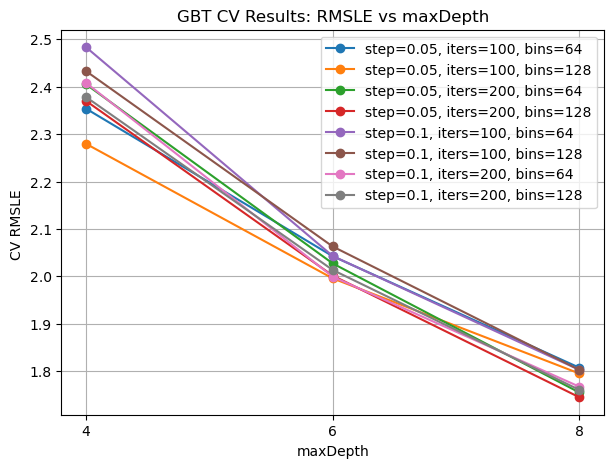

In [31]:
# Plotting for the Hypertuning results
rows = []
for m, pm in zip(avg_rmsle, param_maps):
    rows.append({
        "RMSLE":    float(m),
        "maxIter":  int(pm[gbt.maxIter]),
        "maxDepth": int(pm[gbt.maxDepth]),
        "stepSize": float(pm[gbt.stepSize]),
        "maxBins":  int(pm[gbt.maxBins]),
    })
df = pd.DataFrame(rows).sort_values("RMSLE").reset_index(drop=True)

#Plotting results
plt.figure(figsize=(7,5))

for step in sorted(df["stepSize"].unique()):
    for iters in sorted(df["maxIter"].unique()):
        for bins in sorted(df["maxBins"].unique()):
            sub = df[(df["stepSize"] == step) & 
                     (df["maxIter"] == iters) & 
                     (df["maxBins"] == bins)].sort_values("maxDepth")
            if sub.empty:
                continue
            plt.plot(
                sub["maxDepth"], sub["RMSLE"], marker="o",
                label=f"step={step}, iters={iters}, bins={bins}"
            )

plt.xlabel("maxDepth")
plt.ylabel("CV RMSLE ")
plt.title("GBT CV Results: RMSLE vs maxDepth")
plt.xticks(sorted(df["maxDepth"].unique()))
plt.legend()
plt.grid(True)
plt.show()

As we can see from the graph:
-  The best improvement happened with deeper trees, with depth 8 having consistently higher RMSLE
-  Learning rate, iterations and bins provide marginal improvements, reducing the cross validated RMSLE from 1.82 to 1.73

In [32]:
bestModel= cv_model_gbt.bestModel

print("Best RMSLE on testing:", rmsle_eval.evaluate(cv_model_gbt.transform(test_df)))
print('Best Param for GBT: ', bestModel.stages[-1]._java_obj.paramMap())

Best RMSLE on testing: 1.723956566274159
Best Param for GBT:  {
	GBTRegressor_4ab3eaf8edee-featuresCol: features,
	GBTRegressor_4ab3eaf8edee-labelCol: energy_6h,
	GBTRegressor_4ab3eaf8edee-maxBins: 128,
	GBTRegressor_4ab3eaf8edee-maxDepth: 8,
	GBTRegressor_4ab3eaf8edee-maxIter: 200,
	GBTRegressor_4ab3eaf8edee-stepSize: 0.05
}


After hyperparameter tuning, we managed to reduce the RMSLE from 2.04 all the way to 1.7 for the testing set (and 1.73 cross-validated).

Now that we have a good model, we will save it to use it in task A2B.

In [33]:
#Saving the model
best_model.write().overwrite().save("models/gbt_best_model")

## References:

ROMAN. (n.d.). *EDA for ASHRAE* [Notebook]. Kaggle. 
Retrieved September 27, 2025, from https://www.kaggle.com/code/nroman/eda-for-ashrae